In [70]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg2.0")

import sparg
import importlib
importlib.reload(sparg)
import tskit
import msprime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("always")

In [2]:
ts = tskit.load("two_pops.trees")

np.random.seed(1)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

In [3]:
ts_small, maps_small = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)

location_x = []
composition = []

subpop_and_seq_len = {sample:{ subpop:0 for subpop in range(2)} for sample in ts_small.samples()}

for tree in ts_small.trees():
    for root in tree.roots:
        if ts_small.individual(ts_small.node(root).individual).location[0] < 50:
            subpop = 0
        else:
            subpop = 1
        for sample in tree.samples(root):
            subpop_and_seq_len[sample][subpop] += tree.span

for sample in subpop_and_seq_len:
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    composition.append(subpop_and_seq_len[sample][1] / sum(subpop_and_seq_len[sample].values()))

In [40]:
print(composition)
composition.index(0.614228)

[0.090078, 0.673213, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.321033, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.137045, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.349853, 0.0, 0.342506, 0.614228, 1.0, 1.0, 1.0, 1.0, 0.0, 0.980673, 0.0, 0.0, 0.527283, 0.283789, 0.935019, 0.0, 0.0, 0.0, 0.0, 0.980673, 1.0, 0.0, 0.0, 0.577014, 1.0, 0.0, 0.855859, 0.980673, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.283789, 1.0, 1.0, 0.0, 0.852518, 0.056906, 1.0, 0.0, 0.0, 0.713878, 0.0, 0.0, 0.837704, 0.0, 0.0, 0.0, 1.0, 0.937227, 0.0, 1.0, 1.0, 0.178362, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]


32

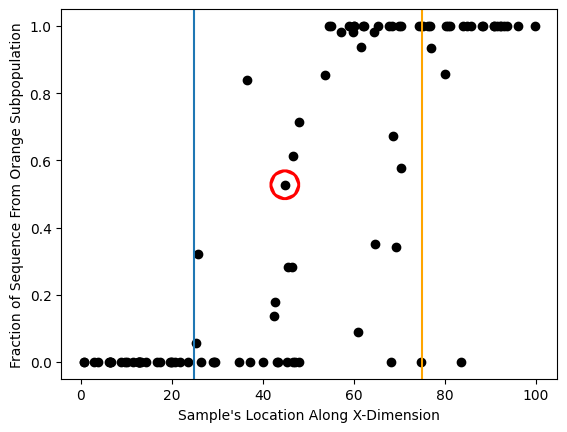

In [55]:
plt.scatter(location_x, composition, color="black")
plt.scatter(location_x[41], composition[41], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction of Sequence From Orange Subpopulation")
plt.savefig("two_pops_composition.svg")
plt.show()

In [5]:
spatial_arg = sparg.SpatialARG(ts=ts_small, verbose=True)
spatial_arg.dispersal_rate_matrix = np.array([[0.25*0.25+0.5,0],[0,0.25*0.25+0.5]])

Prepared input parameters - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1886/1886 [00:01<00:00, 1329.84it/s]


Calculated covariance matrix - Section Elapsed Time: 1.46 - Total Elapsed Time: 1.47
Inverted covariance matrix - Section Elapsed Time: 0.07 - Total Elapsed Time: 1.54
Created root locations vector - Section Elapsed Time: 0.74 - Total Elapsed Time: 2.28
Estimated dispersal rate - Section Elapsed Time: 0.0 - Total Elapsed Time: 2.28
Calculated Fisher's information matrices - Section Elapsed Time: 0.0 - Total Elapsed Time: 2.28
Completed building SpatialARG object - Total Elapsed Time: 2.28


In [56]:
locations_df = sparg.create_ancestors_dataframe(ts=ts_sim, samples=[41], include_locations=True)

In [57]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(df=locations_df, spatial_arg=spatial_arg)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [58]:
locations_df["genome_position"].drop_duplicates()

0       202442.5
1000    416341.0
2000    448156.5
3000    499699.0
4000    552963.5
5000    636244.0
6000    822112.5
7000    973391.0
Name: genome_position, dtype: float64

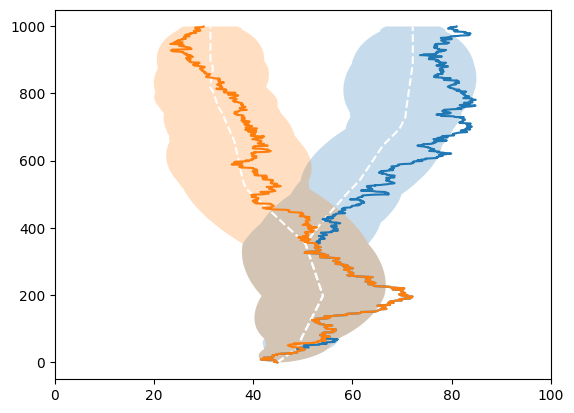

In [60]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    #if i == (32, 546534.5) or i == (32, 780505.0):
    if i == (41, 202442.5) or i == (41, 822112.5):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["arg_estimated_location_0"]-1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
            right.append(row["arg_estimated_location_0"]+1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["arg_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")
#for i,region in locations_df.groupby(["sample", "genome_position"]):
#    plt.plot(region["true_location_0"], region["time"], color="lightgray", zorder=0)
    
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        plt.plot(region["true_location_0"], region["time"])
plt.xlim(0,100)
plt.savefig("two_pops_genetic_ancestors_fixed_confidence.svg")
plt.show()

In [61]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=0, use_theoretical_dispersal=True)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

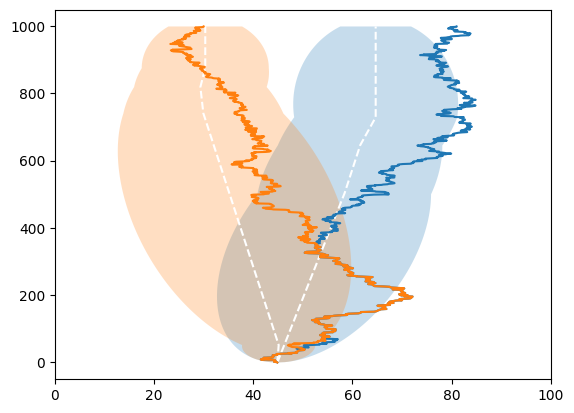

In [62]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_0_estimated_location_0"]-1.96*math.sqrt(round(row["window_0_variance_in_estimated_location_0"],3)))
            right.append(row["window_0_estimated_location_0"]+1.96*math.sqrt(round(row["window_0_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_0_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        plt.plot(region["true_location_0"], region["time"])
plt.xlim(0,100)
plt.savefig("two_pops_genetic_ancestors_fixed_confidence_tree.svg")
plt.show()

In [71]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_tree(df=locations_df, spatial_arg=spatial_arg, use_theoretical_dispersal=True)


KeyboardInterrupt



In [65]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=100, use_theoretical_dispersal=True)

TypeError: estimate_locations_of_ancestors_in_dataframe_using_tree() got an unexpected keyword argument 'window_size'

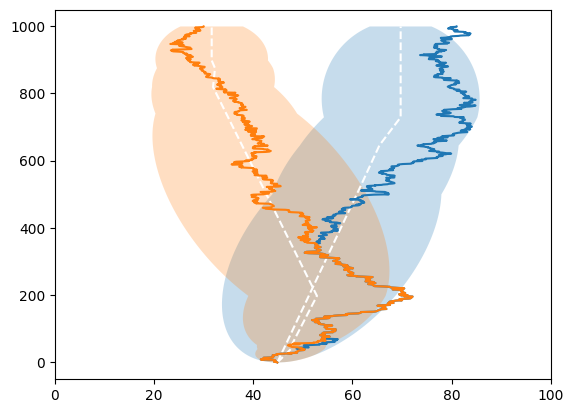

In [12]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_100_estimated_location_0"]-1.96*math.sqrt(round(row["window_100_variance_in_estimated_location_0"],3)))
            right.append(row["window_100_estimated_location_0"]+1.96*math.sqrt(round(row["window_100_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_100_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")  
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        plt.plot(region["true_location_0"], region["time"])
plt.xlim(0,100)
#plt.savefig("two_pops_genetic_ancestors_fixed_confidence_tree.svg")
plt.show()

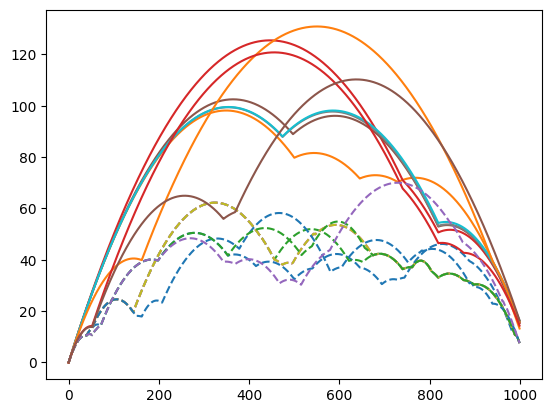

In [81]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    plt.plot(region["time"], region["arg_variance_in_estimated_location_0"], linestyle="dashed")
    plt.plot(region["time"], region["window_0_variance_in_estimated_location_0"])
plt.show()